In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# !slim -d 'OUTPATH="pme.trees"' -d WIDTH=20 -d HEIGHT=2 -d NUMGENS=10000 -d DISPERSAL_SIGMA=0.2 -d SIGMA=0.2 pme.slim  >/dev/null

In [3]:
ts_stationary = pyslim.load("pme_stationary.trees")
ts = pyslim.load("pme.trees")

In [4]:
def lineage_paths(ts):
    # Trace the path of each currently alive individual backward in time and record the location of the ancestor
    # Return (time, x)
    inds = ts.individuals_alive_at(0)
    # Nodes (genomes) of current individuals
    nodes = np.concatenate([ts.individual(i).nodes for i in inds])
    # Times of nodes
    node_times = ts.tables.nodes.time
    # Individual corresponding to each node
    node_indivs = ts.tables.nodes.individual
    # Locations of individuals
    locs = ts.individual_locations
    paths = []
    tree = ts.first()
    for u in nodes:
        uind = node_indivs[u]
        out = [[0, locs[uind, 0]]]
        out.append([node_times[u], locs[uind, 0]])
        u = tree.parent(u)
        while u is not tskit.NULL:
            uind = node_indivs[u]
            out.append([node_times[u], locs[uind, 0]])
            u = tree.parent(u)
        paths.append(np.row_stack(out))
    # Each element of paths is the lineage of one current individual
    return(paths)

In [5]:
paths = lineage_paths(ts)
paths_stationary = lineage_paths(ts_stationary)

In [6]:
# # Plot lineage locations over time
# fig, ax = plt.subplots(figsize=(12, 12))
# for path in paths:
#     ax.plot(path[:,1], path[:,0])

In [7]:
# times to calculate population density at
times = np.linspace(0, np.max(ts.tables.nodes.time), 1000)
times_stationary = np.linspace(0, np.max(ts_stationary.tables.nodes.time), 1000)
# x intervals to calculate population density between
width = 20
loc_intervals = np.linspace(0, width, 20)

def population_size(ts, times, loc_intervals):
    # Calculate population size over time and space
    popsize = np.empty((len(loc_intervals) - 1, len(times)))
    for i in range(len(times)):
        time = times[i]
        indivs = ts.individuals_alive_at(time)
        indiv_locations = ts.individual_locations[indivs]
        xloc = indiv_locations[:,0]
        popsize[:,i] = np.histogram(xloc, bins = loc_intervals)[0]
    return(popsize)

In [8]:
popsize = population_size(ts, times, loc_intervals)
popsize_stationary = population_size(ts_stationary, times_stationary, loc_intervals)

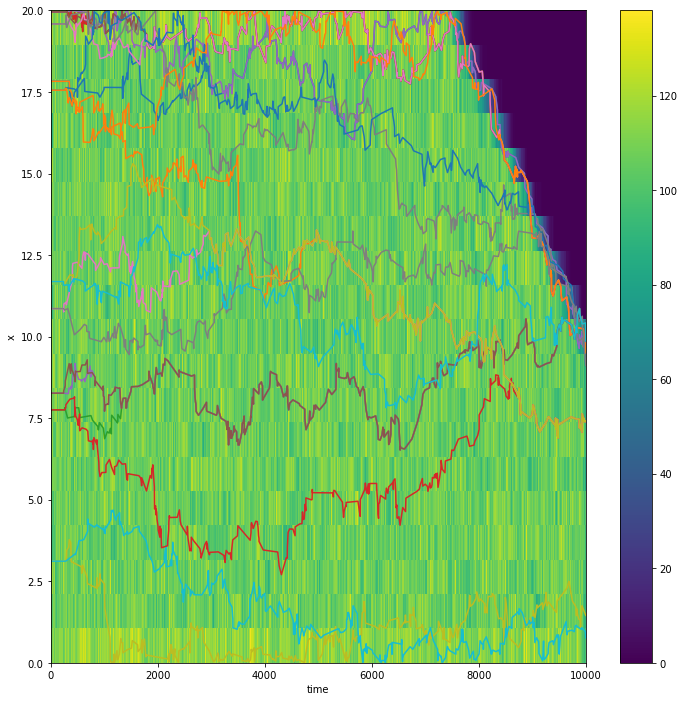

In [9]:
# Plot
fig, ax1 = plt.subplots(1, 1, figsize = (12, 12))
# Plot lineage locations over time
for path in paths[:20]:
    ax1.plot(path[:,0], path[:,1])
c = ax1.pcolormesh(np.concatenate([times, [np.diff(times)[-1] + times[-1]]]), loc_intervals, popsize)
ax1.set(xlabel = "time", ylabel = "x")
fig.colorbar(c)

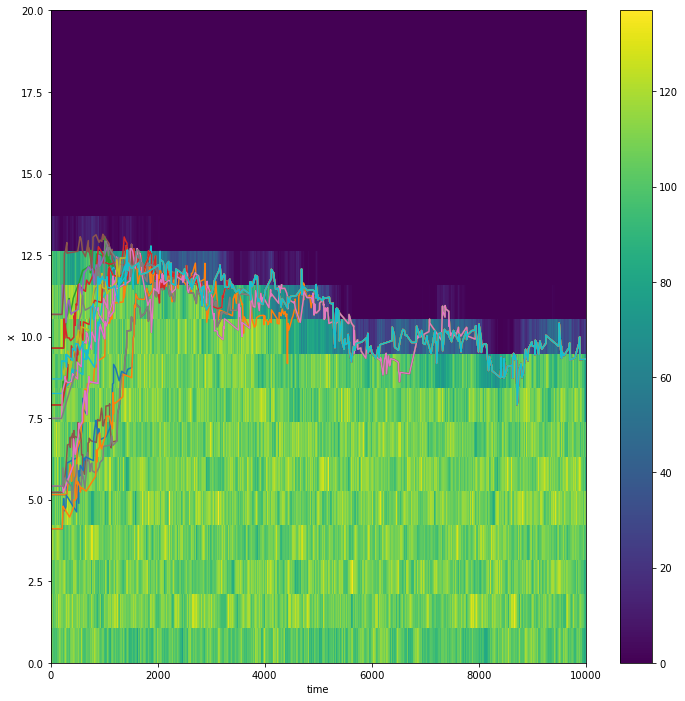

In [10]:
# Stationary wave plot
fig, ax1 = plt.subplots(1, 1, figsize = (12, 12))
# Plot lineage locations over time
for path in paths_stationary[:20]:
    ax1.plot(path[:,0], path[:,1])
c = ax1.pcolormesh(np.concatenate([times_stationary, [np.diff(times_stationary)[-1] + times_stationary[-1]]]), loc_intervals, popsize_stationary)
ax1.set(xlabel = "time", ylabel = "x")
fig.colorbar(c)